# Demo script



Import and examine the version of the Azure ML SDK. This demo was created using the 0.1.65 version of the SDK.

In [81]:
import azureml.core
print("SDK Version: ", azureml.core.__version__)

SDK Version:  0.1.68


## Azure ML Workspaces

A workspace is a ... TODO

This would be a good time to graphically explore the ```TechSummit``` workspace using Visual Studio Code and the Azure ML extension. You can easily see the different kinds of resources that are there. Note that the Visual Studio Code Azure ML extension makes it easy to work with Azure ML workspaces directly from the editor that you're using to create your code. All of the operations that you can do in Visual Studio Code, including examining experiments etc. can be also done _programmatically_ in Azure Notebooks using the AML SDK.

Before we can interact with a workspace, we first need to acquire a reference to it. Create or open the ```TechSummit``` Azure ML workspace. Before you run this, make sure that you **run the Data/Connect to Azure command** from the Jupyter menu above. This will ensure that your Azure login credentials are made available to the code running in this notebook. If you see a device login prompt, this almost always means that you forgot to run the Data/Connect to Azure command.

In [82]:
from azureml.core import Workspace

ws = Workspace.create(name='TechSummit', 
                      subscription_id='15ae9cb6-95c1-483d-a0e3-b1a1a3b06324', 
                      resource_group='juliademo', 
                      location='eastus2',
                      exist_ok=True)
ws.name

'TechSummit'

Before we can submit jobs to the cluster that we saw earlier, we need to retrieve a reference to it. Note that the ```nc6cluster``` has already been created earlier in this demo. The ```ComputeTarget.create``` method can be called to either create or retrieve a reference to an existing cluster; it will not return an error if the cluster already exists.


In [83]:
from azureml.core.compute import BatchAiCompute, ComputeTarget

provisioning_config = BatchAiCompute.provisioning_configuration(vm_size = "STANDARD_NC6",
                                                                autoscale_enabled = True,
                                                                cluster_min_nodes = 10, 
                                                                cluster_max_nodes = 20)

cluster = ComputeTarget.create(ws, 
                               name = "nc6cluster", 
                               provisioning_configuration=provisioning_config)

## Running a simple experiment using our Azure Batch AI cluster

Let's begin by creating a new experiment called ```TechSummitDemo``` in our workspace, and running the ```mnist_with_summaries.py``` file using it. An **Experiment** constructs a reproducible execution environment for running your model training scripts. It does so by creating a **Docker container** for the execution environment for the experiment. The Docker container is saved to the Azure Container Registry in your **Workspace**, ensuring that you will always be able to come back to reproduce the results of this experiment in the future.

Once the container is created, it must be downloaded onto each of the compute nodes on the cluster before the runs can begin. Note that this can take quite some time to complete. But once complete, you now can recreate the environment rapidly by re-running the experiment.

In [84]:
from azureml.core import Experiment

experiment = Experiment(ws, "TechSummitDemo")

Now let's do an experimental run using the ```Experiment``` object that we just created. This experiment takes ~90s to run on the cluster.

In [88]:
from azureml.data.data_reference import DataReference

ds = ws.get_default_datastore()
mnist_data = DataReference(ds, path_on_datastore='mnist')

In [93]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': mnist_data
}

estimator = TensorFlow(source_directory='.',
                       compute_target=cluster,
                       entry_script='tf_mnist.py',
                       script_params=script_params)

run = experiment.submit(estimator)

If we examine the ```run``` object, we can see a link to the Azure Portal that shows a summary of the run.

In [94]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
TechSummitDemo,TechSummitDemo_1540108915198,azureml.scriptrun,Running,Link to Azure Portal,Link to Documentation


## Using HyperDrive to do hyper parameter optimization

ZZZ

Get a reference to the dataset that is stored in the ```TechSummit``` workspace.

Run the hyperparameter training job. Note that this job takes ~22 minutes to run to completion on the provisioned cluster. So we will need to Julia Child this demo.

In [98]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveRunConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import loguniform, uniform

script_params={
    '--data-folder': mnist_data,
}

tf_estimator = TensorFlow(source_directory='.',
                          compute_target=cluster,
                          entry_script='tf_mnist.py',
                          script_params=script_params)

ps = RandomParameterSampling(
    {
        '--learning-rate': loguniform(-15, -3)
    }
)

early_termination_policy = BanditPolicy(slack_factor = 0.15, evaluation_interval=2)

hyperdrive_run_config = HyperDriveRunConfig(estimator = tf_estimator, 
                                            hyperparameter_sampling = ps, 
                                            policy = early_termination_policy,
                                            primary_metric_name = "final_acc",
                                            primary_metric_goal = PrimaryMetricGoal.MAXIMIZE,
                                            max_total_runs = 20,
                                            max_concurrent_runs = 5)

hd_run = experiment.submit(hyperdrive_run_config)

## Deploying the best model

This is where we find the best run in the hyperdrive tuning session, deploy the model to ACI and make a prediction using it. BTW, this method is currently running very slowly. Be patient.

In [99]:
best_run = hd_run.get_best_run_by_primary_metric()

Let's get a list of all of the runs in an experiment.

In [100]:
print(best_run.get_file_names())

['azureml-logs/60_control_log.txt', 'azureml-logs/80_driver_log.txt', 'outputs/model/checkpoint', 'outputs/model/mnist-tf.model.meta', 'outputs/model/mnist-tf.model.index', 'outputs/model/mnist-tf.model.data-00000-of-00001', 'driver_log', 'azureml-logs/azureml.log', 'azureml-logs/55_batchai_execution.txt']


In [110]:
model = best_run.register_model(model_name='tf-dnn-mnist', model_path='outputs/model')

In [111]:
%%writefile score.py
import json
import numpy as np
import os
import tensorflow as tf

from azureml.core.model import Model

def init():
    global X, output, sess
    tf.reset_default_graph()
    model_root = Model.get_model_path('tf-dnn-mnist')
    saver = tf.train.import_meta_graph(os.path.join(model_root, 'mnist-tf.model.meta'))
    X = tf.get_default_graph().get_tensor_by_name("network/X:0")
    output = tf.get_default_graph().get_tensor_by_name("network/output/MatMul:0")
    
    sess = tf.Session()
    saver.restore(sess, os.path.join(model_root, 'mnist-tf.model'))

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    out = output.eval(session = sess, feed_dict = {X: data})
    y_hat = np.argmax(out, axis = 1)
    return json.dumps(y_hat.tolist())

Overwriting score.py


In [112]:
from azureml.core.runconfig import CondaDependencies
cd = CondaDependencies.create()
cd.add_conda_package('numpy')
cd.add_tensorflow_conda_package()
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==0.1.68
- numpy
- tensorflow=1.10.0



In [113]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'name':'mnist', 'framework': 'TensorFlow DNN'},
                                               description='Tensorflow DNN on MNIST from HyperDrive')

In [114]:
from azureml.core.image import ContainerImage
imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
                                               conda_file="myenv.yml")

In [116]:
%%time
from azureml.core.webservice import Webservice

service = Webservice.deploy_from_model(workspace=ws,
                                       name='tf-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=imgconfig)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image tf-mnist-svc:9, operation "Succeeded"
Creating service
Running......................................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 7min 35s


In [117]:
print(service.get_logs())

2018-10-21 09:10:49,620 CRIT Supervisor running as root (no user in config file)
2018-10-21 09:10:49,623 INFO supervisord started with pid 1
2018-10-21 09:10:50,625 INFO spawned: 'rsyslog' with pid 10
2018-10-21 09:10:50,626 INFO spawned: 'program_exit' with pid 11
2018-10-21 09:10:50,627 INFO spawned: 'nginx' with pid 12
2018-10-21 09:10:50,628 INFO spawned: 'iot' with pid 13
2018-10-21 09:10:50,668 INFO spawned: 'gunicorn' with pid 14
2018-10-21 09:10:50,709 INFO success: iot entered RUNNING state, process has stayed up for > than 0 seconds (startsecs)
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2018-10-21 09:10:51,091 INFO exited: iot (exit status 1; expected)
2018-10-21 09:10:52,297 INFO success: rsyslog entered RUNNING state, process has stayed up for > than 1 seconds (startsecs)
2018-10-21 09:10:52,297 INFO success: program_exit entered RUNNING state, process has stayed up for > than 1 seconds (startsecs)
2018-10-21 09:10:56,302 INFO success: nginx 

In [119]:
service.scoring_uri

'http://138.91.120.196:80/score'

In [120]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('data', False)

X_train = mnist.train.images 
X_test = mnist.test.images 

y_train = mnist.train.labels 
y_test = mnist.test.labels 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


POST to url http://138.91.120.196:80/score
label: 8
prediction: "[8]"


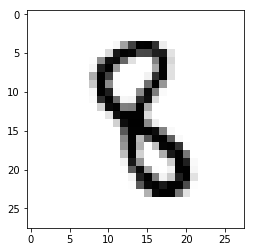

In [134]:
import requests
import json
import matplotlib
import matplotlib.pyplot as plt

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
print("label:", y_test[random_index])
print("prediction:", resp.text)

plt.imshow(X_test[random_index].reshape(28, 28), cmap=plt.cm.Greys)